# Wybór wartości dla zmiennych sterujących dalszym przetwarzaniem

## Ze zrównoważeniem danych trenujących lub bez

W związku z faktem, że dane w analizowanym zbiorze są niezrównoważone w zakresie zmiennej Disbursed czyli y, możliwe są dwie metody przetwarzania:
1. Bez równoważenia danych w zbiorze trenującym - zmienna zrownowaz_dane_train = False
2. Ze zrównoważeniem danych w zbiorze trenującym - zmienna zrownowaz_dane_train = True

Należy mieć na uwadze, że przy wyborze False dla większości zaimplementowanych modeli nie da się obliczyć ROC_AUC (zerowa skuteczność prognozowania "1" dla y)

## Metoda równoważenia danych trenujących

W przypadku wyboru wersji ze zrównoważeniem danych w zbiorze trenującym możliwy jest jeszcze wybór metody zrównoważenia danych. Za wybór metody odpowiada zmienna: wersja1 = True lub False # jeśli False to wybierana jest wersja 2
1. Wybór losowy rekordów ze zbioru z samymi 1 w zmiennej Disnursed (tyle razy ile trzeba by zrównoważyć dane) -to małem pierwotnie,
2. Prosta multiplikacja zbioru z samymi 1 w zmiennej Disbursed (tyle razy ile trzeba by zrównoważyć dane) - chciałem sprawdzić czy to wpłynie na wyniki

In [85]:
zrownowaz_dane_train = True
wersja1 = True

# Wczytanie i przygotowanie danych

In [86]:
import pandas as pd
import numpy as np

In [87]:
# wczytanie zbioru w postaci linku do danych; testowo wybór dwóch systemów kodowania
link_do_danych = "https://raw.githubusercontent.com/saimadhu-polamuri/DataHakthon3X/master/dataSet/Train.csv"
system_kodowania1 = "ISO-8859-1"
system_kodowania2 = "latin"

df1_ = pd.read_csv(link_do_danych, header=0, index_col = 'ID', encoding = system_kodowania1,
                    converters={'Employer_Name': str, 'Salary_Account': str, 'City': str, 'DOB': str}, 
                    parse_dates=['Lead_Creation_Date'])
df2_ = pd.read_csv(link_do_danych, header=0, index_col = 'ID', encoding = system_kodowania2,
                    converters={'Employer_Name': str, 'Salary_Account': str, 'City': str, 'DOB': str}, 
                    parse_dates=['Lead_Creation_Date'])

# uwaga, nie parsuję automatycznie daty urodzenia 'DOB' gdyż read_csv wczytuje lata "dwucyforwe" do roku 68 jak 20XX,
# zamiast (w tym przypadku) jako 19XX

Dalsza analiza prowadzona jest dla danych w: 'df1_'

In [88]:
# usunięcie zmiennej (kolumny): LoggedIn zgodnie z wymogami projektu
df1_ = df1_.drop(columns=["LoggedIn"])

In [89]:
# modyfikacja parametrów wyświetlania liczby kolumn i wierszy z ramki pandas w celu przeglądu danych
with pd.option_context('display.max_rows', 20, 'display.max_columns', 999):
    display(df1_.head(5))

,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,Disbursed
ID,,,,,,,,,,,,,,,,,,,,,,,,
ID000002C20,Female,Delhi,20000,23-May-78,2015-05-15,300000.0,5.0,0.0,CYBOSOL,HDFC Bank,N,0,HBXX,NaN,NaN,NaN,NaN,NaN,N,Web-browser,G,S122,1,0
ID000004E40,Male,Mumbai,35000,07-Oct-85,2015-05-04,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),ICICI Bank,Y,13,HBXA,200000.0,2.0,13.25,NaN,6762.9,N,Web-browser,G,S122,3,0
ID000007H20,Male,Panchkula,22500,10-Oct-81,2015-05-19,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,State Bank of India,Y,0,HBXX,450000.0,4.0,NaN,NaN,NaN,N,Web-browser,B,S143,1,0
ID000008I30,Male,Saharsa,35000,30-Nov-87,2015-05-09,1000000.0,5.0,0.0,BIHAR GOVERNMENT,State Bank of India,Y,10,HBXX,920000.0,5.0,NaN,NaN,NaN,N,Web-browser,B,S143,3,0
ID000009J40,Male,Bengaluru,100000,17-Feb-84,2015-05-20,500000.0,2.0,25000.0,GLOBAL EDGE SOFTWARE,HDFC Bank,Y,17,HBXX,500000.0,2.0,NaN,NaN,NaN,N,Web-browser,B,S134,3,0


In [90]:
# przegląd informacji o danych w df1
df1_.info(20)

<class 'pandas.core.frame.DataFrame'>
Index: 87020 entries, ID000002C20 to ID124821V10
Data columns (total 24 columns):
Gender                   87020 non-null object
City                     87020 non-null object
Monthly_Income           87020 non-null int64
DOB                      87020 non-null object
Lead_Creation_Date       87020 non-null datetime64[ns]
Loan_Amount_Applied      86949 non-null float64
Loan_Tenure_Applied      86949 non-null float64
Existing_EMI             86949 non-null float64
Employer_Name            87020 non-null object
Salary_Account           87020 non-null object
Mobile_Verified          87020 non-null object
Var5                     87020 non-null int64
Var1                     87020 non-null object
Loan_Amount_Submitted    52407 non-null float64
Loan_Tenure_Submitted    52407 non-null float64
Interest_Rate            27726 non-null float64
Processing_Fee           27420 non-null float64
EMI_Loan_Submitted       27726 non-null float64
Filled_Form         

1. Poniżej przekształcam wszystkie daty wg reguły: ROK = 1900 + rr, gdzie rr to dwucyfrowy rok (typ int) wyodrębniony z pola DOB, zawierającego datę urodzenia w postaci string. W analizowanym zbiorze danych problem z datą dotyczy lat 50 - 68, które zamieniam na 1950-1968, podczas gdy read_csv wczytywałby je z automatu jako 2050 - 2068
2. Następnie z tak uzyskanej daty obliczam przybliżony wiek w latach dla każdego wnioskującego o kredyt poprzez odjęcie od daty: Lead_Creation_Date jego daty urodzenia: DOBd (już w formacie daty)
3. Dodatkowy warunek dotyczy sytuacji, w której różnica w latach = 100 (sytuacja ta ma mieksce dla kilkunstu rekordów dla których data Lead_Creation_Date oraz data urodzenia są sobie równe) Wtedy taktujmy to za błąd przy wpisywaniu danych i wstawiamy jako wiek: NaN 

In [91]:
from datetime import datetime
from dateutil import relativedelta

DOBdlst = [] # lista, do której wpiszę poprawnie wyliczone daty urodzenia już w formacie daty
Agelst = [] # lista, do której wpiszę wiek wnioskodawcy wyrażony w latach (od Lead_Creation_Date odejmiemy datę urodzenia)

for i in range (0, len(df1_)):
    DOBstr = df1_['DOB'][i]
    rr = int(DOBstr[-2:])
    rok = 1900 + rr # wyliczenie roku wg podanych wyżej założeń
    DOBstr = DOBstr[0:7]+str(rok) # złączenie roku 4-cyfrowego z dniem i miesiącem daty urodzenia
    DOBdate = datetime.strptime(DOBstr, '%d-%b-%Y') # przekształcenie daty urodzenia na format daty
    DOBdlst.append(DOBdate) # dołączenie danej daty do listy z datami urodzenia
    date_L = df1_['Lead_Creation_Date'][i]
    difference = relativedelta.relativedelta(date_L, DOBdate) # odjęcie od Lead_Creation_Date daty urodzenia wnioskodawcy
    years = difference.years
    if years != 100: # jest kilkanaście rekordów gdzie daty urodzenia i składania wniosku
                     # są sobie równe, co jest niemożliwe, 
                     # ktoś pomylił sie przy wpisywaniu danych
        Agelst.append(years)
    else:
        #print(years)
        Agelst.append(np.nan) # gdy różnica w datach = 100 wstawiamy wartość NaN

# utworzenie nowych pól w df1_ w oparciu o w/w listy
df1_['DOBd'] = DOBdlst
df1_['estimated_age_in_years'] = Agelst

In [92]:
# sprawdzenie efektów zastosowania powyższego algorytmu
kontrolnie1 = df1_.estimated_age_in_years.value_counts().sort_values()
kontrolnie1

71.0       1
86.0       1
78.0       1
66.0       1
82.0       1
77.0       1
69.0       3
73.0       4
72.0       4
68.0       5
67.0       6
65.0      12
62.0      22
17.0      25
61.0      27
63.0      28
64.0      42
60.0      49
59.0      81
58.0     102
56.0     130
57.0     148
18.0     189
55.0     234
54.0     240
53.0     281
52.0     297
19.0     324
51.0     325
50.0     360
49.0     367
48.0     385
46.0     474
47.0     476
44.0     556
43.0     616
20.0     705
42.0     769
41.0     803
45.0     987
40.0    1047
39.0    1179
38.0    1383
21.0    1402
37.0    1617
36.0    1929
22.0    2658
35.0    2664
34.0    3270
33.0    3603
23.0    4070
32.0    4170
31.0    4779
24.0    5290
30.0    5588
29.0    6220
28.0    6485
25.0    6627
27.0    6959
26.0    6981
Name: estimated_age_in_years, dtype: int64

In [93]:
df1_.head()

,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,...,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,Disbursed,DOBd,estimated_age_in_years
ID,,,,,,,,,,,,,,,,,,,,,
ID000002C20,Female,Delhi,20000,23-May-78,2015-05-15,300000.0,5.0,0.0,CYBOSOL,HDFC Bank,...,NaN,NaN,N,Web-browser,G,S122,1,0,1978-05-23,36.0
ID000004E40,Male,Mumbai,35000,07-Oct-85,2015-05-04,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),ICICI Bank,...,NaN,6762.9,N,Web-browser,G,S122,3,0,1985-10-07,29.0
ID000007H20,Male,Panchkula,22500,10-Oct-81,2015-05-19,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,State Bank of India,...,NaN,NaN,N,Web-browser,B,S143,1,0,1981-10-10,33.0
ID000008I30,Male,Saharsa,35000,30-Nov-87,2015-05-09,1000000.0,5.0,0.0,BIHAR GOVERNMENT,State Bank of India,...,NaN,NaN,N,Web-browser,B,S143,3,0,1987-11-30,27.0
ID000009J40,Male,Bengaluru,100000,17-Feb-84,2015-05-20,500000.0,2.0,25000.0,GLOBAL EDGE SOFTWARE,HDFC Bank,...,NaN,NaN,N,Web-browser,B,S134,3,0,1984-02-17,31.0


In [94]:
# zapis danych lokalnie na dysk (wykorzystywany w początkowej fazie analizy, w celu przeglądu danych)
#df1_.to_csv(path_or_buf = 'dane/df1_d1.csv', encoding='utf-8')

Dalsza analiza prowadzona jest dla danych w: _df1_

In [95]:
#usunięcie zbędnych kolumn z datami, zostawiam tylko wiek
df1 = df1_.drop(columns=["Lead_Creation_Date", "DOB", "DOBd"])
df1.head(3)

,Gender,City,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,Mobile_Verified,Var5,...,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,Disbursed,estimated_age_in_years
ID,,,,,,,,,,,,,,,,,,,,,
ID000002C20,Female,Delhi,20000,300000.0,5.0,0.0,CYBOSOL,HDFC Bank,N,0,...,NaN,NaN,NaN,N,Web-browser,G,S122,1,0,36.0
ID000004E40,Male,Mumbai,35000,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),ICICI Bank,Y,13,...,13.25,NaN,6762.9,N,Web-browser,G,S122,3,0,29.0
ID000007H20,Male,Panchkula,22500,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,State Bank of India,Y,0,...,NaN,NaN,NaN,N,Web-browser,B,S143,1,0,33.0


In [96]:
# wyświeltenie informacji o typach zmiennych w ramce: df1
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87020 entries, ID000002C20 to ID124821V10
Data columns (total 23 columns):
Gender                    87020 non-null object
City                      87020 non-null object
Monthly_Income            87020 non-null int64
Loan_Amount_Applied       86949 non-null float64
Loan_Tenure_Applied       86949 non-null float64
Existing_EMI              86949 non-null float64
Employer_Name             87020 non-null object
Salary_Account            87020 non-null object
Mobile_Verified           87020 non-null object
Var5                      87020 non-null int64
Var1                      87020 non-null object
Loan_Amount_Submitted     52407 non-null float64
Loan_Tenure_Submitted     52407 non-null float64
Interest_Rate             27726 non-null float64
Processing_Fee            27420 non-null float64
EMI_Loan_Submitted        27726 non-null float64
Filled_Form               87020 non-null object
Device_Type               87020 non-null object
Var2      

In [97]:
# przegląd wartości wybranych zmiennych
df1.Gender.value_counts()

Male      49848
Female    37172
Name: Gender, dtype: int64

In [98]:
df1.Filled_Form.value_counts()

N    67530
Y    19490
Name: Filled_Form, dtype: int64

In [99]:
df1.Var1.value_counts()

HBXX    59294
HBXC     9010
HBXB     4479
HAXA     2909
HBXA     2123
HAXB     2011
HBXD     1964
HAXC     1536
HBXH      970
HCXF      722
HAYT      508
HAVC      384
HAXM      268
HCXD      237
HCYS      217
HVYS      186
HAZD      109
HCXG       78
HAXF       15
Name: Var1, dtype: int64

In [100]:
df1.Var2.value_counts()

B    37280
G    33032
C    14210
E     1315
D      634
F      544
A        5
Name: Var2, dtype: int64

In [101]:
df1.Var4.value_counts()

3    25260
1    23906
5    20266
4     6577
2     5931
0     2546
7     2302
6      232
Name: Var4, dtype: int64

In [102]:
df1.Var5.value_counts()

0     29087
1     12236
3      6759
11     5204
2      4485
14     3662
15     3509
12     2989
13     2622
8      2515
10     2427
9      2281
16     2097
4      1815
17     1691
7      1489
6       983
5       975
18      194
Name: Var5, dtype: int64

In [103]:
df1.City.value_counts()

Delhi                  12527
Bengaluru              10824
Mumbai                 10795
Hyderabad               7272
Chennai                 6916
Pune                    5207
Kolkata                 2888
Ahmedabad               1788
Jaipur                  1331
Gurgaon                 1212
Coimbatore              1147
                        1003
Thane                    905
Chandigarh               870
Surat                    802
Visakhapatnam            764
Indore                   734
Vadodara                 624
Nagpur                   594
Lucknow                  580
Ghaziabad                560
Bhopal                   513
Kochi                    492
Patna                    461
Faridabad                447
Madurai                  375
Noida                    373
Gautam Buddha Nagar      338
Dehradun                 314
Raipur                   289
                       ...  
VIRPUR                     1
Dhalai                     1
Munger                     1
Kishanganj    

In [104]:
df1.Employer_Name.value_counts()

0                                                     4914
TATA CONSULTANCY SERVICES LTD (TCS)                    550
COGNIZANT TECHNOLOGY SOLUTIONS INDIA PVT LTD           404
ACCENTURE SERVICES PVT LTD                             324
GOOGLE                                                 301
HCL TECHNOLOGIES LTD                                   250
ICICI BANK LTD                                         239
INDIAN AIR FORCE                                       191
INFOSYS TECHNOLOGIES                                   181
GENPACT                                                179
IBM CORPORATION                                        173
INDIAN ARMY                                            171
TYPE SLOWLY FOR AUTO FILL                              162
WIPRO TECHNOLOGIES                                     155
HDFC BANK LTD                                          148
IKYA HUMAN CAPITAL SOLUTIONS LTD                       142
STATE GOVERNMENT                                       1

In [105]:
df1.Device_Type.value_counts()

Web-browser    64316
Mobile         22704
Name: Device_Type, dtype: int64

In [106]:
df1.Source.value_counts()

S122    38567
S133    29885
S159     5599
S143     4332
S127     1931
S137     1724
S134     1301
S161      769
S151      720
S157      650
S153      494
S156      308
S144      299
S158      208
S123       73
S141       57
S162       36
S124       24
S160       11
S150       10
S155        4
S138        3
S136        3
S129        3
S139        3
S135        2
S154        1
S130        1
S125        1
S140        1
Name: Source, dtype: int64

In [107]:
df1.Salary_Account.value_counts()

HDFC Bank                                          17695
ICICI Bank                                         13636
State Bank of India                                11843
                                                   11764
Axis Bank                                           8783
Citibank                                            2376
Kotak Bank                                          2067
IDBI Bank                                           1550
Punjab National Bank                                1201
Bank of India                                       1170
Bank of Baroda                                      1126
Standard Chartered Bank                              995
Canara Bank                                          990
Union Bank of India                                  951
Yes Bank                                             779
ING Vysya                                            678
Corporation bank                                     649
Indian Overseas Bank           

In [108]:
df1.Mobile_Verified.value_counts()

Y    56481
N    30539
Name: Mobile_Verified, dtype: int64

## Podsumowanie przeglądu zmiennych
## Kwestia zakresu zmiennych uwzględnianych w modelach
Na podstawie dostępnych informacji o tym co zawierają poszczególne pola, w/w przeglądu wartości w wybranych polach oraz merytorycznego - bankowego podejścia do tematu domniemuję, że następujące pola nie powinny istotnie rzutować na udzielenie pożyczki lub też ze względów merytorycznych nie należy ich brać pod uwagę:

=> Var1, Var2, Var4, Var5, Source
Brak konkretnych informacji co dane pole zawiera,

=> Employer_Name, Salary_Account, Interest_Rate, Processing_Fee, City,
Na decyzję o udzieleniu pożyczki nie powinny wpływać: Nazwa pracodawcy, nazwa banku gdzie przelewane jest wynagrodzenie, poziom oprocentowania, prowizja, a bardzo możliwe, że również miasto aktualnego pobytu kredytobiorcy jak i jego wiek (to jest do sprawdzenia, przy krótkookresowej pożyczce nie powiniem mieć dużego znaczenia).

W relatywnie niewielkim stopniu powinny też rzutować na wyniki zmienne typu: płeć (Gender), wiek (estimated_age_in_years), Mobile_Verified, Filled_Form, Device_Type.

Dlatego też w dalszej części zmienne te będę grupami usuwał i testował modele bez wybranej ich części lub całości.
Wpierw jednak poddam część z nich etykietowaniu (na wartości numeryczne), gdyż zawierają dane tekstowe.

Na podstawie analizy nazw pól oraz dostępnej informacji w internecie, przyjmuję ponadto, że jeśli dla danego wnioskodawcy, pola: 'Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'EMI_Loan_Submitted' są puste to do finalnej analizy wniosku kredytowego brano pod uwagę wartości z pól: 'Loan_Amount_Applied' oraz 'Loan_Tenure_Applied', 'Existing_EMI'
W związku z tym poniżej przenoszę odpowiednie wartości z pól "applied" do "submited" (jeśli są puste) i w dalszej części biorę pod uwagę już tylko pola "submited", a 'applied' usuwam.

## Zmienne podstawowe (mające merytorycznie zasadniczy wpływ na wynik klasyfikacji)

Zmienne które uznaję za mające znaczący wpływ na wynik są następujące:
Monthly_Income, Loan_Amount_Submitted, Loan_Tenure_Submitted, EMI_Loan_Submitted

In [109]:
df1['Loan_Amount_Submitted'].fillna(df1['Loan_Amount_Applied'], inplace=True)
df1['Loan_Tenure_Submitted'].fillna(df1['Loan_Tenure_Applied'], inplace=True)
df1['EMI_Loan_Submitted'].fillna(df1['Existing_EMI'], inplace=True)

In [110]:
# usuwam pola typu 'Applied' oraz 'Existing Emi'
df1 = df1.drop(columns=["Loan_Tenure_Applied", "Loan_Amount_Applied", "Existing_EMI"])

In [111]:
# usuwam wiersze z danymi NaN dla zmiennej: Loan_Amount_Submited
df1.dropna(axis=0, subset=["Loan_Amount_Submitted", "EMI_Loan_Submitted"], inplace=True)

In [112]:
# usuwam wiersze z danymi NaN dla zmiennej: Existing_EMI - niewykorzystywane, używane tylko podczas testów
#df1.dropna(axis=0, subset=['Existing_EMI'], inplace=True)

In [113]:
#Sprawdzenie ile jest danych z brakującymi wartościami
df1.isnull().sum()

Gender                        0
City                          0
Monthly_Income                0
Employer_Name                 0
Salary_Account                0
Mobile_Verified               0
Var5                          0
Var1                          0
Loan_Amount_Submitted         0
Loan_Tenure_Submitted         0
Interest_Rate             59252
Processing_Fee            59558
EMI_Loan_Submitted            0
Filled_Form                   0
Device_Type                   0
Var2                          0
Source                        0
Var4                          0
Disbursed                     0
estimated_age_in_years       17
dtype: int64

In [114]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86978 entries, ID000002C20 to ID124821V10
Data columns (total 20 columns):
Gender                    86978 non-null object
City                      86978 non-null object
Monthly_Income            86978 non-null int64
Employer_Name             86978 non-null object
Salary_Account            86978 non-null object
Mobile_Verified           86978 non-null object
Var5                      86978 non-null int64
Var1                      86978 non-null object
Loan_Amount_Submitted     86978 non-null float64
Loan_Tenure_Submitted     86978 non-null float64
Interest_Rate             27726 non-null float64
Processing_Fee            27420 non-null float64
EMI_Loan_Submitted        86978 non-null float64
Filled_Form               86978 non-null object
Device_Type               86978 non-null object
Var2                      86978 non-null object
Source                    86978 non-null object
Var4                      86978 non-null int64
Disbursed     

Dla: Gender, Mobile_Verified, Device_Type używam pd.get_dummies (poniżej)

In [115]:
# podział danych w kolumnach wg wartości
dummies = pd.get_dummies(df1[['Filled_Form', 'Gender', 'Mobile_Verified', 'Device_Type']])

In [116]:
dummies.head(2)

,Filled_Form_N,Filled_Form_Y,Gender_Female,Gender_Male,Mobile_Verified_N,Mobile_Verified_Y,Device_Type_Mobile,Device_Type_Web-browser
ID,,,,,,,,
ID000002C20,1,0,1,0,1,0,0,1
ID000004E40,1,0,0,1,0,1,0,1


In [117]:
# usunięcie części zbędnych kolumn z df1
tmp1 = df1.drop(columns=["Filled_Form", "Gender", "Mobile_Verified", "Device_Type"])

Dalsze przetwarzanie dla Xf1

In [118]:
# połączenie tmp1 z dummies, przy czym jako, że w poszczególnych kolumnach znajdowały się tylko dwie wartości
# wybieram jedną z nich: _Y oraz _Mobile
Xf1 = pd.concat([tmp1, dummies[['Gender_Male', 'Filled_Form_Y', 'Mobile_Verified_Y', 'Device_Type_Mobile']]], axis = 1)

In [119]:
Xf1.head()

,City,Monthly_Income,Employer_Name,Salary_Account,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Var2,Source,Var4,Disbursed,estimated_age_in_years,Gender_Male,Filled_Form_Y,Mobile_Verified_Y,Device_Type_Mobile
ID,,,,,,,,,,,,,,,,,,,,
ID000002C20,Delhi,20000,CYBOSOL,HDFC Bank,0,HBXX,300000.0,5.0,NaN,NaN,0.0,G,S122,1,0,36.0,0,0,0,0
ID000004E40,Mumbai,35000,TATA CONSULTANCY SERVICES LTD (TCS),ICICI Bank,13,HBXA,200000.0,2.0,13.25,NaN,6762.9,G,S122,3,0,29.0,1,0,1,0
ID000007H20,Panchkula,22500,ALCHEMIST HOSPITALS LTD,State Bank of India,0,HBXX,450000.0,4.0,NaN,NaN,0.0,B,S143,1,0,33.0,1,0,1,0
ID000008I30,Saharsa,35000,BIHAR GOVERNMENT,State Bank of India,10,HBXX,920000.0,5.0,NaN,NaN,0.0,B,S143,3,0,27.0,1,0,1,0
ID000009J40,Bengaluru,100000,GLOBAL EDGE SOFTWARE,HDFC Bank,17,HBXX,500000.0,2.0,NaN,NaN,25000.0,B,S134,3,0,31.0,1,0,1,0


## Wspomniane wyżej etykietowanie wybranych zmiennych (zamiana wartości tekstowych na etykiety numeryczne)

In [120]:
# zdefiniowanie listy ze zmiennych do labelizacji
Vars_To_Labelize = ["City", "Employer_Name", "Salary_Account", "Source", "Var1", "Var2"]

In [121]:
from sklearn import preprocessing

def labelize(df, VarsToLabelize):
    
    """
    Parametry:
        df (Pandas Dataframe): zbiór danych w postaci dataframe,
            zawierający m. in. kolumny z danymi do "etykietowania"
        VarsToLabelize (list): lista zmiennych, którym chcemy przypisać etykiety 
            numeryczne przy wykorzystaniu LabelEncoder()
    Returns (zwraca): 
        zbiór danych df, zawierający wygenerowane przez LabelEncoder()
        etykiety numeryczne dla podanych kolumn w zmiennej VarsToLabelize
    w ramce danych: df
    """
    # inicalizacja LabelEncoder'a
    lbencdr = preprocessing.LabelEncoder()
    labels_str = '_labels'
    for labelVar in VarsToLabelize:
        lbencdr.fit(df[labelVar])
        labelVar_label = labelVar + labels_str
        df[labelVar_label] = lbencdr.transform(df[labelVar])
    return
        

In [122]:
labelize(Xf1, Vars_To_Labelize)
Xf1.head()

,City,Monthly_Income,Employer_Name,Salary_Account,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,...,Gender_Male,Filled_Form_Y,Mobile_Verified_Y,Device_Type_Mobile,City_labels,Employer_Name_labels,Salary_Account_labels,Source_labels,Var1_labels,Var2_labels
ID,,,,,,,,,,,,,,,,,,,,,
ID000002C20,Delhi,20000,CYBOSOL,HDFC Bank,0,HBXX,300000.0,5.0,NaN,NaN,...,0,0,0,0,173,8692,21,0,13,6
ID000004E40,Mumbai,35000,TATA CONSULTANCY SERVICES LTD (TCS),ICICI Bank,13,HBXA,200000.0,2.0,13.25,NaN,...,1,0,1,0,447,38691,23,0,8,6
ID000007H20,Panchkula,22500,ALCHEMIST HOSPITALS LTD,State Bank of India,0,HBXX,450000.0,4.0,NaN,NaN,...,1,0,1,0,498,1834,45,16,13,1
ID000008I30,Saharsa,35000,BIHAR GOVERNMENT,State Bank of India,10,HBXX,920000.0,5.0,NaN,NaN,...,1,0,1,0,569,5699,45,16,13,1
ID000009J40,Bengaluru,100000,GLOBAL EDGE SOFTWARE,HDFC Bank,17,HBXX,500000.0,2.0,NaN,NaN,...,1,0,1,0,88,13514,21,8,13,1


In [123]:
#usunięcie zmiennych poddanych labelizacji
Xf1 = Xf1.drop(columns=Vars_To_Labelize)

In [124]:
Xf1.head()

,Monthly_Income,Var5,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Var4,Disbursed,estimated_age_in_years,Gender_Male,Filled_Form_Y,Mobile_Verified_Y,Device_Type_Mobile,City_labels,Employer_Name_labels,Salary_Account_labels,Source_labels,Var1_labels,Var2_labels
ID,,,,,,,,,,,,,,,,,,,,
ID000002C20,20000,0,300000.0,5.0,NaN,NaN,0.0,1,0,36.0,0,0,0,0,173,8692,21,0,13,6
ID000004E40,35000,13,200000.0,2.0,13.25,NaN,6762.9,3,0,29.0,1,0,1,0,447,38691,23,0,8,6
ID000007H20,22500,0,450000.0,4.0,NaN,NaN,0.0,1,0,33.0,1,0,1,0,498,1834,45,16,13,1
ID000008I30,35000,10,920000.0,5.0,NaN,NaN,0.0,3,0,27.0,1,0,1,0,569,5699,45,16,13,1
ID000009J40,100000,17,500000.0,2.0,NaN,NaN,25000.0,3,0,31.0,1,0,1,0,88,13514,21,8,13,1


In [125]:
Xf1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86978 entries, ID000002C20 to ID124821V10
Data columns (total 20 columns):
Monthly_Income            86978 non-null int64
Var5                      86978 non-null int64
Loan_Amount_Submitted     86978 non-null float64
Loan_Tenure_Submitted     86978 non-null float64
Interest_Rate             27726 non-null float64
Processing_Fee            27420 non-null float64
EMI_Loan_Submitted        86978 non-null float64
Var4                      86978 non-null int64
Disbursed                 86978 non-null int64
estimated_age_in_years    86961 non-null float64
Gender_Male               86978 non-null uint8
Filled_Form_Y             86978 non-null uint8
Mobile_Verified_Y         86978 non-null uint8
Device_Type_Mobile        86978 non-null uint8
City_labels               86978 non-null int64
Employer_Name_labels      86978 non-null int64
Salary_Account_labels     86978 non-null int64
Source_labels             86978 non-null int64
Var1_labels           

In [126]:
Xf1.shape

(86978, 20)

In [127]:
#Sprawdzenie ile jest danych z brakującymi wartościami
Xf1.isnull().sum()

Monthly_Income                0
Var5                          0
Loan_Amount_Submitted         0
Loan_Tenure_Submitted         0
Interest_Rate             59252
Processing_Fee            59558
EMI_Loan_Submitted            0
Var4                          0
Disbursed                     0
estimated_age_in_years       17
Gender_Male                   0
Filled_Form_Y                 0
Mobile_Verified_Y             0
Device_Type_Mobile            0
City_labels                   0
Employer_Name_labels          0
Salary_Account_labels         0
Source_labels                 0
Var1_labels                   0
Var2_labels                   0
dtype: int64

In [128]:
# dodanie wartości średnich do poniższych kolumn zawierających dane NaN
Xf1['Interest_Rate'].fillna(Xf1['Interest_Rate'].mean(), inplace=True) # konieczne gdybym chciała brać pod uwagę tę zmienną
Xf1['Processing_Fee'].fillna(Xf1['Processing_Fee'].mean(), inplace=True) # konieczne gdybym chciała brać pod uwagę tę zmienną
Xf1['estimated_age_in_years'].fillna(Xf1['estimated_age_in_years'].mean(), inplace=True)

In [129]:
# Sprawdzenie jaki jest rozkład wartości zmiennej Disbursed
Xf1.Disbursed.value_counts()

0    85705
1     1273
Name: Disbursed, dtype: int64

## Widać, że wartości: 0 jest wielokrotnie wiecej niż 1. Rozkład zmiennej Disbursed nie jest zbalansowany.
## W związku z tym w dalszej części po podziale zbioru na część treningową i testową zrównoważę rozkład danych 0 i 1 dla zmiennej Disbursed w zbiorze treningowym: X i y. (Opcjonalnie dostępne będzie również przetwarzanie bez zrównoważenia danych)

## Zdefiniowanie postaci zmiennej X i y dla pełnego (pierwotnego) zbioru danych

In [130]:
# zdefiniowanie zmiennej y
y_a = Xf1.Disbursed

In [131]:
#usunięcie zmiennej y z X
X_a = Xf1.drop(columns="Disbursed")

## Podział na dane trenujące i testowe

In [132]:
# załadowanie potrzebnych bibliotek do podziału danych na treningowe i testowe
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

In [133]:
# podział na dane trenujące i testowe na faktycznym zbiorze danych
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, y_a, test_size=0.2, random_state=42)

In [134]:
X_train_a.shape

(69582, 19)

In [135]:
y_train_a.shape

(69582,)

In [136]:
X_train_a.head()

,Monthly_Income,Var5,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Var4,estimated_age_in_years,Gender_Male,Filled_Form_Y,Mobile_Verified_Y,Device_Type_Mobile,City_labels,Employer_Name_labels,Salary_Account_labels,Source_labels,Var1_labels,Var2_labels
ID,,,,,,,,,,,,,,,,,,,
ID065490W00,31000,9,150000.0,2.0,20.000000,1500.000000,7634.37,4,46.0,0,0,1,0,88,170,4,7,10,1
ID076662O20,18000,1,290000.0,4.0,31.500000,5800.000000,10696.25,5,26.0,0,1,1,1,135,17125,21,26,9,2
ID032530E00,29500,4,440000.0,5.0,20.000000,4400.000000,11657.31,5,27.0,1,1,1,1,229,9500,35,7,10,2
ID020123Z30,18000,1,150000.0,2.0,20.000000,1500.000000,7634.37,4,25.0,1,0,1,0,173,16685,0,7,10,1
ID095006C10,151250,12,1000000.0,5.0,19.197474,5131.150839,7295.00,2,37.0,1,0,1,0,372,3298,14,0,13,6


In [137]:
y_train_a.head()

ID
ID065490W00    0
ID076662O20    0
ID032530E00    0
ID020123Z30    0
ID095006C10    0
Name: Disbursed, dtype: int64

## Przetwarzanie warunkowe w celu zrównoważenia danych w zbiorze treningowym

In [138]:
# obliczenia pomocnicze dla metod rownoważaych dane
# połączenie danych treningowych X i y w jeden zbiór danych: Z_train
# (aby następnie zrównoważyć w nim dane i dopiero wtedy z powrotem podzielić na X_train i y_train)

if zrownowaz_dane_train == True:
    Z_train = pd.concat([X_train_a, y_train_a], axis=1)
    #Zdefiniowanie zmiennych zawierających liczbę 0 i 1 w zmiennej Disbursed dla zbioru Z_train
    Disbursed_liczba_wystapien_0, Disbursed_liczba_wystapien_1 = Z_train.Disbursed.value_counts()[0], Z_train.Disbursed.value_counts()[1]
    #wyliczenie w przyblizeniu mnoznika = ile razy będę duplikował dane ze zbioru z samymi wartościami "1" w zmiennej Disbursed
    # oraz reszty => tak by liczba obserwacji z "1" w Disbursed * mnożnik + reszta równała się liczbie obserwacji z "0" w Disbursed)
    mnoznik = int(Disbursed_liczba_wystapien_0/Disbursed_liczba_wystapien_1)
    reszta = Disbursed_liczba_wystapien_0-mnoznik*Disbursed_liczba_wystapien_1

In [139]:
# Wywoływane przy równoważeniu danych, na roboczo, dla sprawdzenia wyników przetwarzania
#Z_train.shape
#Z_train.head()

In [141]:
# Wywoływane przy równoważeniu danych, na roboczo, dla sprawdzenia wyników przetwarzania
#Disbursed_liczba_wystapien_0, Disbursed_liczba_wystapien_1
#mnoznik, reszta

# Dwa sposoby równoważenia danych w zbiorze trenującym:
## wersja 1 - losowanie danych w celu zbalansowania danych testowych (n razy)
## wersja 2 - prosta multiplikacja danych z wartością zmiennej Disbursed = 1 (n razy)
## Uwaga: Stosujemy alternatywnie wersję 1 albo 2

In [143]:
# Wybór wersji równoważenia danych - obecnie na samym początku u góry
# wersja1 = True #jak False to wybrana zostanie wersja 2

Wersja 1
1. Wylosowanie ze zbioru danych zawierajacych 1, liczby obserwacji tylko z wartością "1" dla zmiennej Disbursed; losujemy maksymalnie dostępną liczbę obserwacji tyle razy ile wynosi 'mnożnik'
2. Zapisanie tych danych do dataframe: Z_Disbursed_1

Wersja 2
1. Powielenie zbioru z Dsibursed = "1" tyle razy by otrzymać zrównoważony zbiór treningowy
2. Zapisanie tych danych do dataframe: Z_Disbursed_1

In [144]:
if zrownowaz_dane_train == True:
    if wersja1:
        # tu pierwsze samplowanie
        Z_Disbursed_1 = Z_train.sample(n=Disbursed_liczba_wystapien_1, weights='Disbursed', random_state=42)
        # tu dodanie samplowania dla liczby obserwacji równej reszta = 414
        Zprim = Z_train.sample(n=reszta, weights='Disbursed', random_state=42)
        Z_Disbursed_1 = pd.concat([Z_Disbursed_1, Zprim], ignore_index=True)
        # poniżej generowanie pozostałej liczby wymaganych obserwacji w pętli
        for i in range(0, mnoznik-2):
            Zbis = Z_train.sample(n=Disbursed_liczba_wystapien_1, weights='Disbursed', random_state=42)
            Z_Disbursed_1 = pd.concat([Z_Disbursed_1, Zbis], ignore_index=True)
    else:
        # dodanie samplowania dla liczby obserwacji równej reszta = 414; tylko dla reszty losuję
        Z_Disbursed_1 = Z_train.sample(n=reszta, weights='Disbursed', random_state=42)
        # poniżej generowanie pozostałej liczby wymaganych obserwacji w pętli
        Zbis = Z_train.loc[lambda Z_train: Z_train['Disbursed'] == 1]
        for i in range(0, mnoznik-1):
            Z_Disbursed_1 = pd.concat([Z_Disbursed_1, Zbis], ignore_index=True)
            
    # Połączenie zbioru z danymi surowymi oraz wygenerowanymi w celu zrównowazenia wyników
    Z_train = pd.concat([Z_train, Z_Disbursed_1], ignore_index=True)
    
    ## Zdefiniowanie finalnej postaci zmiennej X i y dla zbioru trenującego
    # zdefiniowanie zmiennej y
    y_train = Z_train.Disbursed
    #usunięcie zmiennej y z X
    X_train = Z_train.drop(columns="Disbursed")
    ## Zdefiniowanie finalnej postaci zmiennej X i y dla zbioru testowego
else:
    # gdy nie równoważymy danych w zbiorze trenującym
    X_train, y_train = X_train_a, y_train_a
    
X_test, y_test = X_test_a, y_test_a

In [212]:
# Wywoływane przy równoważeniu danych, na roboczo, dla sprawdzenia wyników przetwarzania
#Z_Disbursed_1.shape
# Sprawdzenie rozkładu wartości zmiennej Disbursed dla wylosowanych danych
#Z_Disbursed_1.Disbursed.value_counts()

#Z_Disbursed_1.head()
#Z_train.Disbursed.value_counts()

In [149]:
# Można uruchomić krokowo gdy jednak nie chcemy równoważyć danych w zbiorze trenującym
# X_train, y_train = X_train_a, y_train_a

## Sterowanie liczbą zmiennych branych pod uwagę w modelach

## Uwaga, liczbą zmiennych sterujemy zarówno dla zbioru X_train jak i X_test

In [150]:
# usunięcie I grupy zmiennych (do wyboru)
#X_train = X_train.drop(columns=["Employer_Name_labels", "Salary_Account_labels"])
#X_test = X_test.drop(columns=["Employer_Name_labels", "Salary_Account_labels"])

In [151]:
# usunięcie II grupy zmiennych (do wyboru)
#X_train = X_train.drop(columns=["Var4", "Var5", "Var1_labels", "Var2_labels", "Source_labels"])
#X_test = X_test.drop(columns=["Var4", "Var5", "Var1_labels", "Var2_labels", "Source_labels"])

In [152]:
# usunięcie III grupy zmiennych (do wyboru)
#X_train = X_train.drop(columns=["Interest_Rate", "Processing_Fee", "City_labels"])
#X_test = X_test.drop(columns=["Interest_Rate", "Processing_Fee", "City_labels"])

In [153]:
# usunięcie zmiennych o zakładanym teoretycznie, niewielkim wpływie na wyniki
#X_train = X_train.drop(columns=["Gender_Male", "Mobile_Verified_Y", "Filled_Form_Y", "Device_Type_Mobile", "estimated_age_in_years"])
#X_test = X_test.drop(columns=["Gender_Male", "Mobile_Verified_Y", "Filled_Form_Y", "Device_Type_Mobile", "estimated_age_in_years"])
#X_train = X_train.drop(columns=["Gender_Male"])
#X_test = X_test.drop(columns=["Gender_Male"])
#X_train = X_train.drop(columns=["Mobile_Verified_Y"])
#X_test = X_test.drop(columns=["Mobile_Verified_Y"])
#X_train = X_train.drop(columns=["Filled_Form_Y"])
#X_test = X_test.drop(columns=["Filled_Form_Y"])
#X_train = X_train.drop(columns=["Device_Type_Mobile"])
#X_test = X_test.drop(columns=["Device_Type_Mobile"])
#X_train = X_train.drop(columns=["estimated_age_in_years"])
#X_test = X_test.drop(columns=["estimated_age_in_years"])

In [154]:
# Testowo, sprawdzenie jak modele zachowują się bez jednej ze zmiennych podstawowych, 
# które podchodząc merytorycznie do tematu, powinny mieć znaczący wpływ na wynik.
#X_train = X_train.drop(columns=["Monthly_Income"])
#X_test = X_test.drop(columns=["Monthly_Income"])
#X_train = X_train.drop(columns=["Loan_Amount_Submitted"])
#X_test = X_test.drop(columns=["Loan_Amount_Submitted"])
#X_train = X_train.drop(columns=["Loan_Tenure_Submitted"])
#X_test = X_test.drop(columns=["Loan_Tenure_Submitted"])
#X_train = X_train.drop(columns=["EMI_Loan_Submitted"])
#X_test = X_test.drop(columns=["EMI_Loan_Submitted"])

In [155]:
X_train.head()

,Monthly_Income,Var5,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Var4,estimated_age_in_years,Gender_Male,Filled_Form_Y,Mobile_Verified_Y,Device_Type_Mobile,City_labels,Employer_Name_labels,Salary_Account_labels,Source_labels,Var1_labels,Var2_labels
0,31000,9,150000.0,2.0,20.000000,1500.000000,7634.37,4,46.0,0,0,1,0,88,170,4,7,10,1
1,18000,1,290000.0,4.0,31.500000,5800.000000,10696.25,5,26.0,0,1,1,1,135,17125,21,26,9,2
2,29500,4,440000.0,5.0,20.000000,4400.000000,11657.31,5,27.0,1,1,1,1,229,9500,35,7,10,2
3,18000,1,150000.0,2.0,20.000000,1500.000000,7634.37,4,25.0,1,0,1,0,173,16685,0,7,10,1
4,151250,12,1000000.0,5.0,19.197474,5131.150839,7295.00,2,37.0,1,0,1,0,372,3298,14,0,13,6


In [156]:
X_test.head()

,Monthly_Income,Var5,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Var4,estimated_age_in_years,Gender_Male,Filled_Form_Y,Mobile_Verified_Y,Device_Type_Mobile,City_labels,Employer_Name_labels,Salary_Account_labels,Source_labels,Var1_labels,Var2_labels
ID,,,,,,,,,,,,,,,,,,,
ID004662I20,20900,3,300000.0,5.0,19.197474,5131.150839,0.0,3,27.0,0,0,1,1,131,27509,23,7,13,2
ID101036A10,12500,0,100000.0,3.0,19.197474,5131.150839,0.0,1,25.0,0,0,0,0,583,146,4,0,13,6
ID070815R00,20000,0,200000.0,2.0,19.197474,5131.150839,10000.0,1,25.0,0,0,0,0,447,23142,21,26,13,1
ID096153F30,25000,8,300000.0,4.0,19.750000,6000.000000,9089.2,3,25.0,1,0,1,0,447,23949,23,0,18,6
ID025986M10,83500,15,200000.0,2.0,19.197474,5131.150839,29200.0,3,33.0,0,0,1,0,88,19961,21,7,13,1


## Załadowanie potrzebnych bibliotek ML

In [157]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer
import pprint
import scipy
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, recall_score, precision_score

## Dalsze przetwarzanie po finalnym podziale i wyborze danych

In [158]:
# podział na dane trenujące i testowe
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [159]:
# Dodanie możliwości wyświetlania boldem w Pythonie-Jupyterze
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd("**bold**")

**bold**

Sprawdzenie kształtów zbiorów train i test

In [160]:
X_train.shape

(137122, 19)

In [161]:
y_train.shape

(137122,)

In [162]:
X_test.shape

(17396, 19)

In [163]:
y_test.shape

(17396,)

In [164]:
# spojrzenie na rozkład 0 i 1 dla y_train
y_train.value_counts()

1    68561
0    68561
Name: Disbursed, dtype: int64

In [165]:
# spojrzenie na rozkład 0 i 1 dla y_test
y_test.value_counts()

0    17144
1      252
Name: Disbursed, dtype: int64

In [166]:
# ograniczenie informacji typu warning podczas testowania modeli
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [167]:
#definicje zmiennych, modeli oraz zakresu parametrów modeli, które będziemy tunować

names = np.array(["Naiwny Bayes", "Drzewo decyzyjne", "Regresja logistyczna_MaxAbs",
                  "Regresja logistyczna_StandardScaler",  "SVM_MaxAbs", "SVM_StandardScaler",
                 "BaggingClassifier_tree", "BaggingClassifier_Logistic", "RandomForest",
                  "bzprmRandomForest"])

models = [[("model", MultinomialNB())],
         [("model", DecisionTreeClassifier())],
         [("scaler", MaxAbsScaler()), ("model", LogisticRegression())],
          [("scaler", StandardScaler()), ("model", LogisticRegression())],
         [("scaler", MaxAbsScaler()),("model", SVC())],
          [("scaler", StandardScaler()),("model", SVC())],
         [("model", BaggingClassifier(base_estimator=DecisionTreeClassifier()))],
         [("model", BaggingClassifier(base_estimator=LogisticRegression()))],
         [("model", RandomForestClassifier())],
          [("model", RandomForestClassifier(n_estimators=180, min_samples_leaf=3,
                                            max_features=0.5, n_jobs=-1))]
         ]

param_grids = [{"model__alpha": [0.1, 1, 10], "model__fit_prior": [False, True]},
               {"model__criterion": ["gini", "entropy"],
                "model__min_samples_split": [2, 10, 100], "model__max_depth": [None, 2, 10, 100]}, 
               {"model__penalty": ["l1", "l2"], "model__C": [0.001, 0.1, 1, 10, 100]},
               {"model__penalty": ["l1", "l2"], "model__C": [0.001, 0.1, 1, 10, 100]},
              [{"model__kernel": ["rbf"],},
              {"model__kernel": ["poly"], "model__degree": [1, 2, 3, 4]},
              {"model__kernel": ["linear","sigmoid"]}],
               [{"model__kernel": ["rbf"],},
              {"model__kernel": ["poly"], "model__degree": [1, 2, 3, 4]},
              {"model__kernel": ["linear","sigmoid"]}],
               {"model__n_estimators" : [2, 5, 200], "model__max_features": [0.5, 0.8, 0.9, 1.0]},
               {"model__n_estimators" : [2, 5, 200], "model__max_features": [0.5, 0.8, 0.9, 1.0]},
               {"model__n_estimators" : [2, 5, 200], "model__class_weight": ["balanced_subsample", "balanced"]},
               {}
              ]


# tutaj definiuję różne zakresy modeli, które będę testował
#uses = np.array([True, True, True, True, True, True, True, True, True, True]) # odpada, z uwagi na czas wykonywania
#uses = np.array([True, True, True, True, False, False, True, True, True, True]) # wszystko co puszczałem do wyboru najlepszych modeli
#uses = np.array([True, False, False, False, False, False, False, False, False, False])
#uses = np.array([False, False, False, False, True, False, False, False, False, False])
#uses = np.array([False, False, False, False, False, True, False, False, False, False])
#uses = np.array([False, False, False, False, False, False, False, False, False, True])
uses = np.array([False, True, False, False, False, False, True, False, True, True]) # modele w miarę szybkie, które sobie w róznym stopniu radziły

In [168]:
# Wybór najlepszych modeli, prezentacja wyników


if len(names) != len(models) or len(models) != len(param_grids) or len(param_grids) != len(uses):
    print(f"len(names): {len(names)}")
    print(f"len(models): {len(models)}")
    print(f"len(param_grids): {len(param_grids)}")
    print(f"len(uses): {len(uses)}")
    raise ValueError("Listy nie mają tej samej długości!")

# puste listy do których wpisane zostana wybrane parametry i wyniki modeli
best_models = []
best_params = []
best_indexes = []
tab_ROC_AUC = []
tab_accuracy = []
names_rslt = [] # lista z nazwami modeli, które zostały faktycznie przetestowane


for use, name, pipe, params in zip(uses, names, models, param_grids):
    if not use:
        continue
    printmd(f"**Tunuje model: {name}**") 
    pipeline = Pipeline(pipe)
    gs = GridSearchCV(estimator=pipeline, param_grid=params, n_jobs=3)
    gs.fit(X_train, y_train)
    for mean, std, param, fit_time, score_time in zip(gs.cv_results_["mean_test_score"],
                                gs.cv_results_["std_test_score"],
                                gs.cv_results_["params"],
                                gs.cv_results_["mean_fit_time"],
                                gs.cv_results_["mean_score_time"]):
        print("Zastosowane parametry:")
        for i in param.items():
            print(f"\t {i}")
        #print(f"\t {param}:\n\t mean_test_score: {mean}, std_test_score: {std},\n\t mean_fit_time: {fit_time}, mean_score_time: {score_time}\n")
        print(f"Wyniki: \n\t mean_test_score: {round(mean, 4)}, \
              std_test_score: {round(std, 4)}, \
              \n\t mean_fit_time: {round(fit_time, 4)}, \
              mean_score_time: {round(score_time, 4)}\n")
    names_rslt.append(name)
    best_models.append(gs.best_estimator_)
    best_params.append(gs.best_params_)
    best_indexes.append(gs.best_index_)
    
best_models = np.array(best_models)
best_params = np.array(best_params)
best_indexes = np.array(best_indexes)
names_rslt = np.array(names_rslt)


print(f"____________________\n\n")

#print(f"\n")
#printmd(f"**Testuję accuracy:**")
#for name, best_model in zip(names, best_models):
#    if not use:
#        continue
#    tab_accuracy.append(roc_auc_score(best_model.predict(X_test), y_test))
#    print(f"\t {name}: {round(accuracy_score(best_model.predict(X_test), y_test), 4)}")


**Tunuje model: Drzewo decyzyjne**

Zastosowane parametry:
	 ('model__criterion', 'gini')
	 ('model__max_depth', None)
	 ('model__min_samples_split', 2)
Wyniki: 
	 mean_test_score: 0.9898,               std_test_score: 0.0003,               
	 mean_fit_time: 2.9503,               mean_score_time: 0.0693

Zastosowane parametry:
	 ('model__criterion', 'gini')
	 ('model__max_depth', None)
	 ('model__min_samples_split', 10)
Wyniki: 
	 mean_test_score: 0.9896,               std_test_score: 0.0004,               
	 mean_fit_time: 2.864,               mean_score_time: 0.0488

Zastosowane parametry:
	 ('model__criterion', 'gini')
	 ('model__max_depth', None)
	 ('model__min_samples_split', 100)
Wyniki: 
	 mean_test_score: 0.9689,               std_test_score: 0.0012,               
	 mean_fit_time: 2.9216,               mean_score_time: 0.0581

Zastosowane parametry:
	 ('model__criterion', 'gini')
	 ('model__max_depth', 2)
	 ('model__min_samples_split', 2)
Wyniki: 
	 mean_test_score: 0.7332,               std_test_score: 0.0009, 

**Tunuje model: BaggingClassifier_tree**

/home/kodolamacz/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Zastosowane parametry:
	 ('model__max_features', 0.5)
	 ('model__n_estimators', 2)
Wyniki: 
	 mean_test_score: 0.9975,               std_test_score: 0.0002,               
	 mean_fit_time: 1.492,               mean_score_time: 0.0876

Zastosowane parametry:
	 ('model__max_features', 0.5)
	 ('model__n_estimators', 5)
Wyniki: 
	 mean_test_score: 0.9965,               std_test_score: 0.0018,               
	 mean_fit_time: 3.4539,               mean_score_time: 0.1904

Zastosowane parametry:
	 ('model__max_features', 0.5)
	 ('model__n_estimators', 200)
Wyniki: 
	 mean_test_score: 0.9992,               std_test_score: 0.0001,               
	 mean_fit_time: 152.1074,               mean_score_time: 4.8891

Zastosowane parametry:
	 ('model__max_features', 0.8)
	 ('model__n_estimators', 2)
Wyniki: 
	 mean_test_score: 0.9973,               std_test_score: 0.0005,               
	 mean_fit_time: 2.7976,               mean_score_time: 0.1073

Zastosowane parametry:
	 ('model__max_features', 0.8)

**Tunuje model: RandomForest**

Zastosowane parametry:
	 ('model__class_weight', 'balanced_subsample')
	 ('model__n_estimators', 2)
Wyniki: 
	 mean_test_score: 0.9979,               std_test_score: 0.0002,               
	 mean_fit_time: 1.7413,               mean_score_time: 0.1162

Zastosowane parametry:
	 ('model__class_weight', 'balanced_subsample')
	 ('model__n_estimators', 5)
Wyniki: 
	 mean_test_score: 0.9972,               std_test_score: 0.0001,               
	 mean_fit_time: 2.843,               mean_score_time: 0.145

Zastosowane parametry:
	 ('model__class_weight', 'balanced_subsample')
	 ('model__n_estimators', 200)
Wyniki: 
	 mean_test_score: 0.9995,               std_test_score: 0.0,               
	 mean_fit_time: 108.5553,               mean_score_time: 4.4199

Zastosowane parametry:
	 ('model__class_weight', 'balanced')
	 ('model__n_estimators', 2)
Wyniki: 
	 mean_test_score: 0.9978,               std_test_score: 0.0001,               
	 mean_fit_time: 0.9104,               mean_score_time: 0.0729


**Tunuje model: bzprmRandomForest**

Zastosowane parametry:
Wyniki: 
	 mean_test_score: 0.9985,               std_test_score: 0.0002,               
	 mean_fit_time: 143.9021,               mean_score_time: 4.9924

____________________




In [169]:
print(f"\n")
printmd(f"**Testuję ROC_AUC (jeśli możliwa do obliczenia):**")
for name, best_model in zip(names_rslt, best_models):
    #print(f"\nConfusion matrix ma postać:")
    #print(f" {name}")
    cm = confusion_matrix(best_model.predict(X_test), y_test)
    #print(cm)
    if cm[1,1] !=0: 
        tab_ROC_AUC.append(roc_auc_score(best_model.predict(X_test), y_test))
        print(f"{name}: {round(roc_auc_score(best_model.predict(X_test), y_test), 4)}")
    else:
        # jeśli przez model wyznaczana jest tylko jedna wartość dla y czyli "0" 
        # to nie liczymy ROC_AUC, z założenia wstawiam nan w takim przypadku.
        tab_ROC_AUC.append(np.nan)


printmd(f"**Testuję accuracy:**")
for name, best_model in zip(names_rslt, best_models):
    tab_accuracy.append(accuracy_score(best_model.predict(X_test), y_test))
    print(f"{name}: {round(accuracy_score(best_model.predict(X_test), y_test), 4)}")
    print(f"Confusion matrix ma postać:")
    cm = confusion_matrix(best_model.predict(X_test), y_test)
    print(cm)
    print(f"\n")

**Testuję ROC_AUC (jeśli możliwa do obliczenia):**

Drzewo decyzyjne: 0.5309
BaggingClassifier_tree: 0.524
RandomForest: 0.5261
bzprmRandomForest: 0.5261


**Testuję accuracy:**

Drzewo decyzyjne: 0.9732
Confusion matrix ma postać:
[[16911   233]
 [  233    19]]


BaggingClassifier_tree: 0.9847
Confusion matrix ma postać:
[[17129   251]
 [   15     1]]


RandomForest: 0.9848
Confusion matrix ma postać:
[[17130   251]
 [   14     1]]


bzprmRandomForest: 0.984
Confusion matrix ma postać:
[[17116   250]
 [   28     2]]




## Zestawienie wyników (ze względu na wynik ACCURACY)

In [198]:
# wpisanie wybranych parametrów i wyników testowanych modeli do ramki danych pandas
# posłuży mi to również do porównania wyników danego i poprzedniego przebiegu uczenia i testowania modeli
# (powyżej, przejściowo, będę miał wyniki bieżące, a poniżej te z poprzedniego przetwarzania,
# dopóki finalnie nie uruchomie kodu tu zawartego)
miary_wynikowe = ['BEST_PARAMS', 'ACCURACY', 'ROC_AUC']
zestawienie_wynikow = pd.DataFrame(list(zip(best_params, tab_accuracy, tab_ROC_AUC)), index = names_rslt, columns= miary_wynikowe)

pd.set_option('display.max_colwidth', 800)
zestawienie_wynikow.sort_values("ACCURACY", ascending=False)

,BEST_PARAMS,ACCURACY,ROC_AUC
RandomForest,"{'model__class_weight': 'balanced_subsample', 'model__n_estimators': 200}",0.984767,0.526113
BaggingClassifier_tree,"{'model__max_features': 0.8, 'model__n_estimators': 200}",0.984709,0.524029
bzprmRandomForest,{},0.984019,0.526135
Drzewo decyzyjne,"{'model__criterion': 'entropy', 'model__max_depth': 100, 'model__min_samples_split': 2}",0.973212,0.530903


# Podsumowanie wyników
Niestety dla wszystkich kombinacji zbiorów testowych wynik modeli w zakresie ROC_AUC wychodzi słaby bo w okolicach 0,5 - 0,53.
1. Jeśli nie równoważymy danych testowych to w zasadzie tylko dla RandomForest można było wyliczyć ROC_AUC (przy minimum zmiennych) pozostałe modele (drzewo decyzyjne, BaggingClassifier_tree, bzprmRandomForest) notowały zerową skuteczność predykcji "1" w zmiennej y.
Jednocześnie, modele te osiągają wyniki w ACCURACY na poziomie 0,966 - 0,985 (choć akurat Random Forest ma nieco słabe niż reszta).
2. Jeśli równoważymy dane testowe to wyniki ROC_AUC tylko minimalnie się polepszają (0,53 - Drzewo decyzyjne, wszystkie zmienne) natomiast accuracy pozostaje na podobnym poziomie. 


Co do zmiennych, które w założeniach uznałem za mało znaczące: "Gender_Male", "Mobile_Verified_Y", "Filled_Form_Y", "Device_Type_Mobile", "estimated_age_in_years" to przy równoważeniu danych testowych mają one pewien niewielki wpływ na wyniki (setne cześci wyniku)

## Poniżej dodatkowe, niezależne rozwiązanie przy zastosowaniu xgboost
XGBRegressor (objective ='reg:logistic')

In [191]:
#!pip install xgboost

In [180]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, recall_score, precision_score
from termcolor import colored

In [181]:
if zrownowaz_dane_train == True:
    # Połączenie zbiorów treningowych (ze zrównoważonymi danymi 0 i 1 dla zmiennej Disbursed) oraz testowych
    # w jeden zbiór: X i y w celu zdefiniowania xgb.Dmatrix
    X = pd.concat([X_test, X_train], axis=0)
    y = pd.concat([y_test, y_train], axis=0)

else:
    # Zdefiniowanie finalnych postaci zmiennych X i y w przypadku rezygnacji z równoważenia 0 i 1 w zbiorze trenującym
    X_test, y_test = X_test_a, y_test_a
    X_train, y_train = X_train_a, y_train_a
    X, y = X_a, y_a

In [182]:
X.shape

(154518, 19)

In [183]:
y.shape

(154518,)

In [184]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [185]:
xgb_model = xgb.XGBRegressor(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 7, alpha = 10, n_estimators = 200)

In [186]:
xgb_model.fit(X_train,y_train)
predict_eval = xgb_model.predict(X_test)

In [187]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, predict_eval))
print("RMSE: %f" % (rmse))

RMSE: 0.279623


In [210]:
# Obliczenie ROC_AUC, wyznaczenie krzywej i powierzchni pod krzywą ROC
#fpr - macierz wyników false positive - narastająco
#tpr - macierz wyników true positive - narastająco
fpr, tpr, _ = roc_curve(y_test, predict_eval)
roc_auc = auc(fpr, tpr)
tab_ROC_AUC.append(roc_auc)
print(colored('ROC AUC wynosi: ', 'green'), colored(round(roc_auc, 4), 'green'))
cm = confusion_matrix((predict_eval > 0.5), y_test)
print(colored('Confusion Matrix ma postać: ', 'green'),'\n', cm)
accuracy = (cm[0,0] + cm[1,1])/(cm[0,0] + cm[1,1]+cm[1,0] + cm[0,1])
print(colored('ACCURACY wynosi: ', 'red'), colored(round(accuracy, 4), 'red'))
tab_accuracy.append(accuracy)

ROC AUC wynosi:  0.8298
Confusion Matrix ma postać:  
 [[15199   131]
 [ 1945   121]]
ACCURACY wynosi:  0.8807


Regressor wyraźnie lepiej predykuje "1" w y jednakże pogarsza się predykcja dla "0" i wynik ogolny ACCURACY.

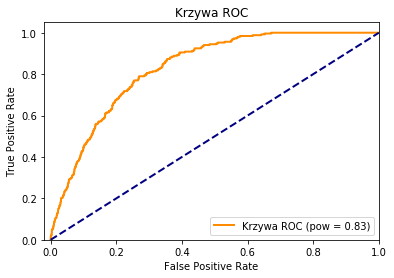

In [207]:
    #xgb.plot_importance(gbm)
    #plt.show()
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='Krzywa ROC (pow = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Krzywa ROC')
    plt.legend(loc="lower right")
    plt.show()

## Poniżej są już tylko kontrolne wyświetlenia wybranych zmiennych

In [171]:
best_model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [172]:
#cm = confusion_matrix(best_model.predict(X_test), y_test)
#print(cm)

In [173]:
best_indexes

array([21,  5,  2,  0])

In [174]:
best_models

array([Pipeline(memory=None,
     steps=[('model', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=100,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       Pipeline(memory=None,
     steps=[('model', BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
     ...mators=200, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False))]),
       Pipeline(memory=None,
     steps=[('model', RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini'

In [175]:
best_params

array([{'model__criterion': 'entropy', 'model__max_depth': 100, 'model__min_samples_split': 2},
       {'model__max_features': 0.8, 'model__n_estimators': 200},
       {'model__class_weight': 'balanced_subsample', 'model__n_estimators': 200},
       {}], dtype=object)

In [176]:
tab_ROC_AUC

[0.5309030323904332,
 0.5240290563866513,
 0.5261128051703968,
 0.5261353602825444]

In [177]:
tab_accuracy

[0.9732122326971717, 0.9847091285352955, 0.9847666130144861, 0.984019314785008]

In [ ]:
#with pd.option_context('display.max_rows', 999, 'display.max_columns', 999):
#    display(X.head(10))